

# DDPM using the three middle slices of ADC images from The Dallas Lifespan Brain Study & HCP Young Adult

This tutorial illustrates how to use MONAI for training a denoising diffusion probabilistic model (DDPM)[1] to create
synthetic 2D images.

[1] - Ho et al. "Denoising Diffusion Probabilistic Models" https://arxiv.org/abs/2006.11239

## Setup imports

In [1]:


%reset

Nothing done.


In [1]:
import os
import shutil
import tempfile
import time
import glob

from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import numpy as np
import csv
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import CacheDataset, DataLoader, Dataset
from monai.utils import first, set_determinism
from monai.data.utils import pad_list_data_collate
from torch.amp import GradScaler, autocast
from tqdm import tqdm
import random

import pandas as pd

import nibabel as nib

from monai.inferers import DiffusionInferer
from monai.networks.nets import DiffusionModelUNet
from monai.networks.schedulers import DDPMScheduler

from monai.metrics import compute_iou

#print_config()

In [2]:
DEVICE_TYPE = "cuda:1"

In [3]:
ROOT_DIR = "/home/fehrdelt/bettik/"
#ROOT_DIR = "/bettik/PROJECTS/pr-gin5_aini/fehrdelt/"



In [4]:
set_determinism(0)

## Setup Dallas Healthy Lifespan ADC Dataset and training and validation dataloaders

2D 128x128 slices of 3D ADC volumes

In [5]:
IMAGE_SIZE = 128

In [6]:
train_csv = os.path.join(ROOT_DIR, "Code/data_splits_lists/ADC_Dallas_and_HCP-YA/train.csv")
train_images_path = []

with open(train_csv, mode='r') as file:
    reader = csv.reader(file)
    for line in tqdm(reader):
        #print(line)
        train_images_path.append(ROOT_DIR+line[0])

val_csv = os.path.join(ROOT_DIR, "Code/data_splits_lists/ADC_Dallas_and_HCP-YA/val.csv")
val_images_path = []

with open(val_csv, mode='r') as file:
    reader = csv.reader(file)
    for line in tqdm(reader):

        val_images_path.append(ROOT_DIR+line[0])

test_reconstruction_csv = os.path.join(ROOT_DIR, "Code/data_splits_lists/ADC_Dallas_and_HCP-YA/test.csv")
test_reconstruction_images_path = []

with open(test_reconstruction_csv, mode='r') as file:
    reader = csv.reader(file)
    for line in tqdm(reader):

        test_reconstruction_images_path.append(ROOT_DIR+line[0])


1572it [00:00, 50210.91it/s]
197it [00:00, 14247.15it/s]
197it [00:00, 88192.75it/s]


In [7]:
test_unhealthy_csv = os.path.join(ROOT_DIR, "Code/data_splits_lists/ADC_aini-stroke_unhealthy_test/ADC_aini-stroke_unhealthy_test.csv")
test_unhealthy_images_path = []

with open(test_unhealthy_csv, mode='r') as file:
    reader = csv.reader(file)
    for line in tqdm(reader):

        test_unhealthy_images_path.append(ROOT_DIR+line[0])

445it [00:00, 93962.21it/s]


In [8]:
#train_datalist = sorted(train_images_path)
train_datalist = train_images_path

#val_datalist = sorted(val_images_path)
val_datalist = val_images_path

#val_datalist = sorted(val_images_path)
test_reconstruction_datalist = test_reconstruction_images_path

test_unhealthy_datalist = test_unhealthy_images_path

batch_size = 64
num_workers = 4


In [9]:
class Get2DSlice(transforms.Transform):
    """
    Fetch the middle slice of a 3D volume.
    Args:
        axis: The axis along which to slice the volume. 0 for axial, 1 for coronal, 2 for sagittal.
        offset : Offset the index by a specified amount (default=0)
    """

    def __init__(
        self,
        axis: int = 0,
        offset: int=0
    ):
        super().__init__()
        self.axis = axis
        self.offset = offset

    def __call__(self, data):
        #print(data.shape)
        if self.axis==0:
            return data[:, data.shape[1]//2+self.offset,:,:]
        elif self.axis==1:
            return data[:, :,data.shape[2]//2+self.offset,:]
        elif self.axis==2:
            return data[:, :, :,data.shape[3]//2+self.offset]

In [10]:
class Get2DSliceWithRandomOffset(transforms.RandomizableTransform):
    """
    Will return the middle slice with a random offset in addition to the specified fixed offset.
    Args:
        axis: The axis along which to slice the volume. 0 for axial, 1 for coronal, 2 for sagittal.
        offset : Offset the index by a specified amount (default=0)
    """

    def __init__(
        self,
        axis: int = 0,
        fixed_offset: int=0
    ):
        super().__init__()
        self.axis = axis
        self.fixed_offset = fixed_offset
        self.rand_offset = 0


    def randomize(self):
        super().randomize(None)
        self.rand_offset = random.randint(-1, 1)

    def __call__(self, data):
        #print(data.shape)
        self.randomize()

        #print(self.rand_offset)
        if self.axis==0:
            return data[:, data.shape[1]//2+self.fixed_offset+self.rand_offset,:,:]
        elif self.axis==1:
            return data[:, :,data.shape[2]//2+self.fixed_offset+self.rand_offset,:]
        elif self.axis==2:
            return data[:, :, :,data.shape[3]//2+self.fixed_offset+self.rand_offset]

In [ ]:

train_transforms = transforms.Compose(
    [
        transforms.LoadImage(),
        transforms.EnsureChannelFirst(),
        transforms.RandAffine(prob=0.2, rotate_range=(0.15, 0.15, 0.15)),#+- 0.15 radians for each axis
        Get2DSliceWithRandomOffset(axis=2, fixed_offset=0), #28
        transforms.ScaleIntensityRange(a_min=0.0, a_max=4000.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.RandScaleCrop(roi_scale=0.9, max_roi_scale=1.1, random_size=True),
        transforms.ResizeWithPadOrCrop(spatial_size=(128, 128)),
    ]
)
train_ds = CacheDataset(data=train_datalist, transform=train_transforms) #TODO datalist[:32]
train_loader = DataLoader(
    #collate_fn=pad_list_data_collate: any tensors are centrally padded to match the shape of the biggest tensor in each dimension
    train_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, persistent_workers=True, collate_fn=pad_list_data_collate
)



In [ ]:


val_transforms = transforms.Compose(
    [
        transforms.LoadImage(),
        transforms.EnsureChannelFirst(),
        Get2DSlice(axis=2, offset=0),  # 28
        transforms.ScaleIntensityRange(a_min=0.0, a_max=4000.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.ResizeWithPadOrCrop(spatial_size=(128, 128)),
    ]
)
val_ds = CacheDataset(data=val_datalist, transform=val_transforms)
val_loader = DataLoader(
    val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, persistent_workers=True
)


In [ ]:



test_reconstruction_transforms = transforms.Compose(
    [
        transforms.LoadImage(),
        transforms.EnsureChannelFirst(),
        Get2DSlice(axis=2, offset=0),
        transforms.ScaleIntensityRange(a_min=0.0, a_max=4000.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.ResizeWithPadOrCrop(spatial_size=(128, 128)),
    ]
)
test_reconstruction_ds = CacheDataset(data=test_reconstruction_datalist, transform=test_reconstruction_transforms)
test_reconstruction_loader = DataLoader(
    test_reconstruction_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, persistent_workers=True
)


In [ ]:
test_unhealthy_transforms = transforms.Compose(
    [
        transforms.LoadImage(),
        transforms.EnsureChannelFirst(),
        Get2DSlice(axis=2),
        transforms.ScaleIntensityRange(a_min=0.0, a_max=4000.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.ResizeWithPadOrCrop(spatial_size=(128, 128)),
    ]
)
test_unhealthy_ds = CacheDataset(data=test_unhealthy_datalist, transform=test_unhealthy_transforms)
test_unhealthy_loader = DataLoader(
    test_unhealthy_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, persistent_workers=True
)

### Visualisation of the training images

In [ ]:

for i, batch in enumerate(train_loader):
    #print(i)
    if i==0:
     
        print(f"batch shape: {batch.shape}")
        image_visualisation0 = torch.cat(
            [batch[0, 0], batch[1, 0], batch[2, 0], batch[3, 0]], dim=1
        )
        image_visualisation1 = torch.cat(
            [batch[4, 0], batch[5, 0], batch[6, 0], batch[7, 0]], dim=1
        )
        image_visualisation2 = torch.cat(
            [batch[8, 0], batch[9, 0], batch[10, 0], batch[11, 0]], dim=1
        )
        image_visualisation3 = torch.cat(
            [batch[12, 0], batch[13, 0], batch[14, 0], batch[15, 0]], dim=1
        )
        fig, (ax0, ax1, ax2, ax3) = plt.subplots(4,figsize=(12, 12))
        
        ax0.imshow(image_visualisation0, cmap="gray")
        ax1.imshow(image_visualisation1, cmap="gray")
        ax2.imshow(image_visualisation2, cmap="gray")
        ax3.imshow(image_visualisation3, cmap="gray")
        plt.axis("off")
        plt.tight_layout()
        plt.show()


In [ ]:

for i, batch in enumerate(val_loader):
    #print(i)
    if i==2:
     
        print(f"batch shape: {batch.shape}")
        image_visualisation0 = torch.cat(
            [batch[0, 0], batch[1, 0], batch[2, 0], batch[3, 0]], dim=1
        )
        image_visualisation1 = torch.cat(
            [batch[4, 0], batch[5, 0], batch[6, 0], batch[7, 0]], dim=1
        )
        image_visualisation2 = torch.cat(
            [batch[8, 0], batch[9, 0], batch[10, 0], batch[11, 0]], dim=1
        )
        image_visualisation3 = torch.cat(
            [batch[12, 0], batch[13, 0], batch[14, 0], batch[15, 0]], dim=1
        )
        fig, (ax0, ax1, ax2, ax3) = plt.subplots(4,figsize=(12, 12))
        
        ax0.imshow(image_visualisation0, cmap="gray")
        ax1.imshow(image_visualisation1, cmap="gray")
        ax2.imshow(image_visualisation2, cmap="gray")
        ax3.imshow(image_visualisation3, cmap="gray")
        plt.axis("off")
        plt.tight_layout()
        plt.show()


In [ ]:

for i, batch in enumerate(test_reconstruction_loader):
    #print(i)
    if i==0:
     
        print(f"batch shape: {batch.shape}")
        image_visualisation0 = torch.cat(
            [batch[0, 0], batch[1, 0], batch[2, 0], batch[3, 0]], dim=1
        )
        image_visualisation1 = torch.cat(
            [batch[4, 0], batch[5, 0], batch[6, 0], batch[7, 0]], dim=1
        )
        image_visualisation2 = torch.cat(
            [batch[8, 0], batch[9, 0], batch[10, 0], batch[11, 0]], dim=1
        )
        image_visualisation3 = torch.cat(
            [batch[12, 0], batch[13, 0], batch[14, 0], batch[15, 0]], dim=1
        )
        fig, (ax0, ax1, ax2, ax3) = plt.subplots(4,figsize=(12, 12))
        
        ax0.imshow(image_visualisation0, cmap="gray")
        ax1.imshow(image_visualisation1, cmap="gray")
        ax2.imshow(image_visualisation2, cmap="gray")
        ax3.imshow(image_visualisation3, cmap="gray")
        plt.axis("off")
        plt.tight_layout()
        plt.show()


### Define network, scheduler, optimizer, and inferer
At this step, we instantiate the MONAI components to create a DDPM, the UNET, the noise scheduler, and the inferer used for training and sampling. We are using
the original DDPM scheduler containing 1000 timesteps in its Markov chain, and a 2D UNET with attention mechanisms
in the 2nd and 3rd levels, each with 1 attention head.

In [11]:
device = torch.device(DEVICE_TYPE)

model = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(64, 128, 128),
    attention_levels=(False, True, True),
    num_res_blocks=1,
    num_head_channels=(0, 128, 128),
)
model.to(device)

num_train_timesteps = 1000 #TODO vu que je fais de la détec d'anomalies, pas besoin d'aller jusqu'à 1000 (full bruit) je peux faire 200 par ex
scheduler = DDPMScheduler(num_train_timesteps=num_train_timesteps)

optimizer = torch.optim.Adam(params=model.parameters(), lr=2.5e-5)

inferer = DiffusionInferer(scheduler)

### Model training
Here, we are training our model for 75 epochs (training time: ~50 minutes).

In [ ]:
writer = SummaryWriter(ROOT_DIR+"Code/Tensorboard/Experiment_1-2_3_slices_per_patient")

max_epochs = 6000
val_interval = 3
epoch_loss_list = []
val_epoch_loss_list = []

best_val_epoch_loss = np.inf
best_val_epoch = 0

scaler = GradScaler(DEVICE_TYPE)
total_start = time.time()
for epoch in range(max_epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch.to(device)
        optimizer.zero_grad(set_to_none=True)

        with autocast(device_type=DEVICE_TYPE, enabled=True):
            # Generate random noise
            noise = torch.randn_like(images).to(device)

            # Create timesteps
            timesteps = torch.randint(0, num_train_timesteps, (images.shape[0],), device=images.device).long()

            # Get model prediction
            noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)

            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

        epoch_len = len(train_ds)
        

        progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})

    epoch_loss_list.append(epoch_loss / (step + 1))
    writer.add_scalar("train_loss", epoch_loss / (step + 1), epoch)

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_epoch_loss = 0
        for step, batch in enumerate(val_loader):
            images = batch.to(device)
            with torch.no_grad(), autocast(device_type=DEVICE_TYPE, enabled=True):
                noise = torch.randn_like(images).to(device)
                timesteps = torch.randint(0, num_train_timesteps, (images.shape[0],), device=images.device).long()
                noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)
                val_loss = F.mse_loss(noise_pred.float(), noise.float())

            val_epoch_loss += val_loss.item()

            progress_bar.set_postfix({"val_loss": val_epoch_loss / (step + 1)})

        val_epoch_loss_list.append(val_epoch_loss / (step + 1))
        writer.add_scalar("val_loss", val_epoch_loss / (step + 1), epoch)   # moi

        if val_epoch_loss < best_val_epoch_loss:
            best_val_epoch_loss = val_epoch_loss
            best_val_epoch = epoch + 1
            torch.save(
                model.state_dict(),
                os.path.join(ROOT_DIR+"Code/Best_models/2d_ddpm_tutorial", "Experiment_1-2_ADC_best_metric_model_dallas_and_hcp_ya_3slices_per_patient.pth"),
            )
            print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current val loss: {val_epoch_loss:.4f}"
                f"\nbest val loss: {best_val_epoch_loss:.4f}"
                f" at epoch: {best_val_epoch}"
            )


        if (epoch + 1) % (val_interval*4) == 0:
            # Sampling image during training
            noise = torch.randn((1, 1, IMAGE_SIZE, IMAGE_SIZE))
            noise = noise.to(device)
            scheduler.set_timesteps(num_inference_steps=1000)
            with autocast(device_type=DEVICE_TYPE, enabled=True):
                image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler)

            plt.figure(figsize=(2, 2))
            plt.imshow(image[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
            plt.tight_layout()
            plt.axis("off")
            plt.show()

total_time = time.time() - total_start
print(f"train completed, total time: {total_time}.")

In [ ]:
print(best_val_epoch)

### Tests

### Reconstruction quality of unseen healthy brains

In [12]:
model.load_state_dict(torch.load(os.path.join(ROOT_DIR+"Code/Best_models/2d_ddpm_tutorial", "Experiment_1-2_ADC_best_metric_model_dallas_and_hcp_ya_3slices_per_patient.pth"), map_location=DEVICE_TYPE))
model.eval()

DiffusionModelUNet(
  (conv_in): Convolution(
    (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (time_embed): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock(
      (resnets): ModuleList(
        (0): DiffusionUNetResnetBlock(
          (norm1): GroupNorm(32, 64, eps=1e-06, affine=True)
          (nonlinearity): SiLU()
          (conv1): Convolution(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-06, affine=True)
          (conv2): Convolution(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (skip_connection): Identity()
        )
      )
      (downsampler): DiffusionUne

### Test Reconstruction Quality: PSNR & SSIM

In [ ]:
from monai.metrics import PSNRMetric, SSIMMetric, MultiScaleSSIMMetric

In [ ]:
ms_ssim = MultiScaleSSIMMetric(spatial_dims=2, data_range=1.0)
ssim = SSIMMetric(spatial_dims=2, data_range=1.0)

psnr_metric = PSNRMetric(max_val=1.0)

print("Computing MS-SSIM & PSNR...")
ms_ssim_list = []
ssim_list = []

psnr_list = []

pbar = tqdm(enumerate(test_reconstruction_loader), total=len(test_reconstruction_loader))
for step, batch in pbar:
    test_image = batch.to(device)


    scheduler.set_timesteps(num_inference_steps=1000)

    timesteps = torch.FloatTensor([NOISE_AMOUNT for i in range(test_image.shape[0])]).to(device).long()

    noise = torch.randn_like(test_image).to(device)

    noisy_image = scheduler.add_noise(original_samples=test_image, noise=noise, timesteps=timesteps)

    with autocast(device_type=DEVICE_TYPE, enabled=True):
        infered_image, intermediates = my_sample(noisy_image, progress_bar=False, intermediate_steps=10)

    #ms_ssim_list.append(ms_ssim(test_image, infered_image).item())
    #print(ssim(test_image, infered_image).detach().cpu().numpy())
    #print(ssim(test_image, infered_image).detach().cpu().numpy().flatten())
    ssim_list.append(np.mean(ssim(test_image, infered_image).detach().cpu().numpy().flatten()))

    #print(psnr_metric(infered_image/np.max(infered_image), test_image/np.max(infered_image)).detach().cpu().numpy().flatten())
    psnr_list.append(psnr_metric(infered_image/np.max(infered_image), test_image/np.max(infered_image)).detach().cpu().numpy().flatten())
    
    pbar.update()

print(f"With {NOISE_AMOUNT} noise amount")
print(f"With {num_infer_timesteps} inference timesteps")
print(f"Mean PSNR: {np.mean(psnr_list[0]):.6f}")
print(f"Mean SSIM: {np.mean(ssim_list):.6f}")

#ms_ssim_list = np.array(ms_ssim_list)
#print(f"Mean MS-SSIM: {ms_ssim_list.mean():.6f}")

### Anomaly Map
https://github.com/Project-MONAI/tutorials/blob/main/generation/anomaly_detection/anomaly_detection_with_transformers.ipynb

In [13]:
unhealthy_aini_stroke_ADC = ["final_aini-stroke-22082_563324_ADC_DIFF_EPI_3_NEX_ADC.nii.gz"]
unhealthy_adc_datalist = [ROOT_DIR+"datasets/Aini-Stroke_ADC/Others_extracted_brain_registered_resampled/"+file for file in unhealthy_aini_stroke_ADC]

ISLES_ADC_datalist = sorted(glob.glob(ROOT_DIR+"datasets/ISLES_ADC_registered_resampled/*.nii.gz"))

problematic_images_indexes = [59,100,101,136,152,153,161,163,164,165,166,181,183,184,185,187,188,190,192, #TODO: va falloir régler les pb sur ces images, ça a l'air d'être la partie ou je fais rotate90 qui foire (peut être avec le remplacement de la matrice affine)
                              193,194,196,198,199,201,205,206,207,208,214,218,221,225,228,229,235,237,238,
                              240,242,244,247,248,249]
problematic_images = [os.path.basename(ISLES_ADC_datalist[i]) for i in problematic_images_indexes]
ISLES_ADC_datalist = [image for image in ISLES_ADC_datalist if os.path.basename(image) not in problematic_images]
#print(ISLES_ADC_datalist[:10])
ISLES_masks_datalist = sorted(glob.glob(ROOT_DIR+"datasets/ISLES_masks_registered_resampled/*.nii.gz"))
ISLES_masks_datalist = [image for image in ISLES_masks_datalist]
ISLES_masks_datalist = [image for image in ISLES_masks_datalist if os.path.basename(image).replace('msk', 'adc') not in problematic_images]
#print(ISLES_masks_datalist[:10])
#print(problematic_images)

In [14]:
num_workers = 4
ano_batch_size = 10

test_anomaly_transforms = transforms.Compose(
    [
        transforms.LoadImage(),
        transforms.EnsureChannelFirst(),
        Get2DSlice(axis=2, offset=+2),
        transforms.ScaleIntensity(minv=0.0, maxv=3000.0),
        transforms.ScaleIntensityRange(a_min=0.0, a_max=2300.0, b_min=0.0, b_max=1.0, clip=True), # change a_max to increase or decrease intensity of the images after transformation
        transforms.ResizeWithPadOrCrop(spatial_size=(128, 128)),
    ]
)
test_anomaly_ds = CacheDataset(data=ISLES_ADC_datalist, transform=test_anomaly_transforms) # TODO ISLES_ADC_datalist[:10]

anomaly_batch_size = 10

test_anomaly_loader = DataLoader(
    test_anomaly_ds, batch_size=ano_batch_size, shuffle=False, num_workers=num_workers, persistent_workers=True
)

Loading dataset:   0%|                                                                                                                            | 0/206 [00:00<?, ?it/s]

Loading dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 206/206 [01:03<00:00,  3.22it/s]


In [15]:

test_masks_transforms = transforms.Compose(
    [
        transforms.LoadImage(),
        transforms.EnsureChannelFirst(),
        Get2DSlice(axis=2, offset=+2),
        transforms.ResizeWithPadOrCrop(spatial_size=(128, 128)),
    ]
)
test_masks_ds = CacheDataset(data=ISLES_masks_datalist, transform=test_masks_transforms) # TODO ISLES_ADC_datalist[:10]


test_masks_loader = DataLoader(
    test_masks_ds, batch_size=ano_batch_size, shuffle=False, num_workers=num_workers, persistent_workers=True
)

Loading dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 206/206 [00:43<00:00,  4.73it/s]


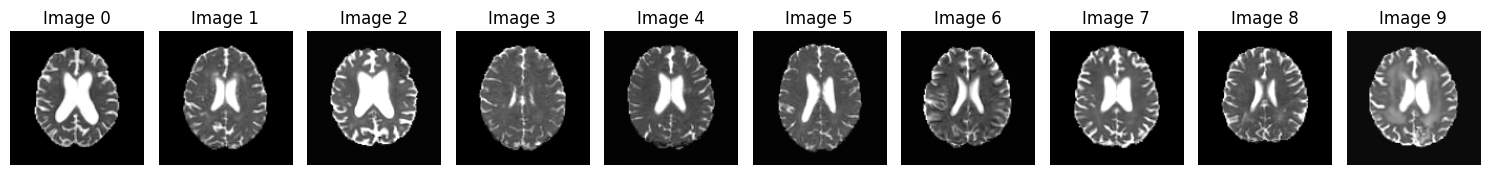

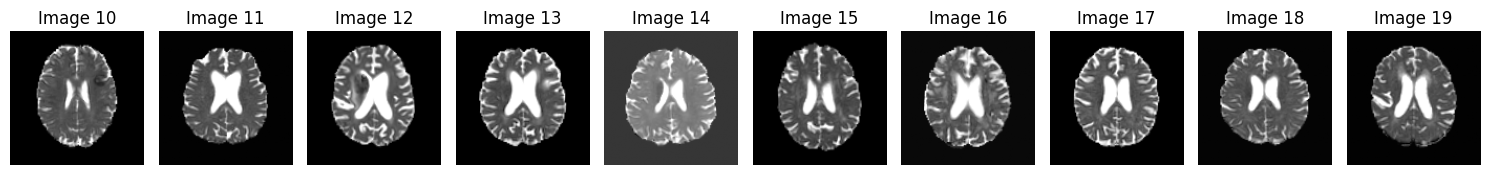

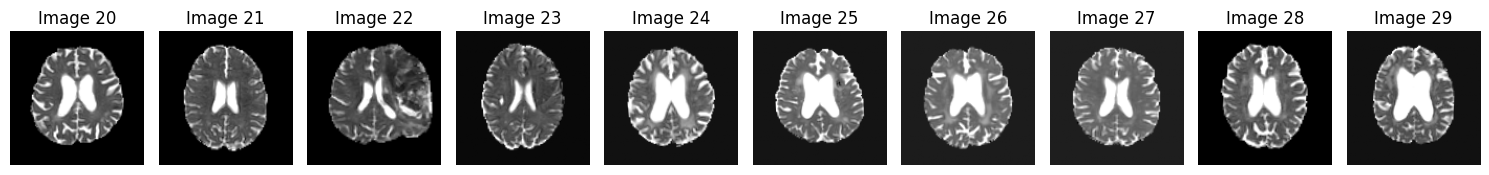

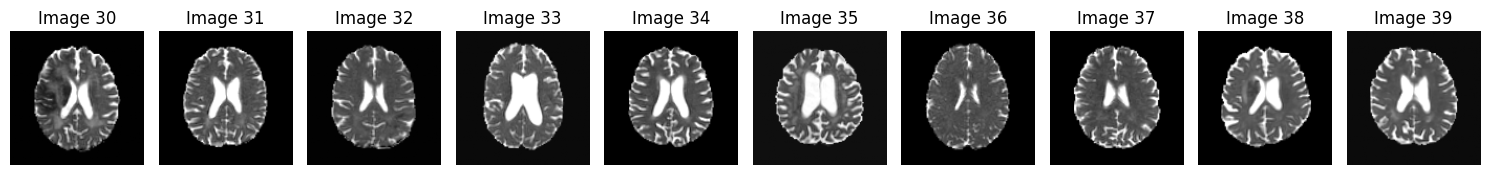

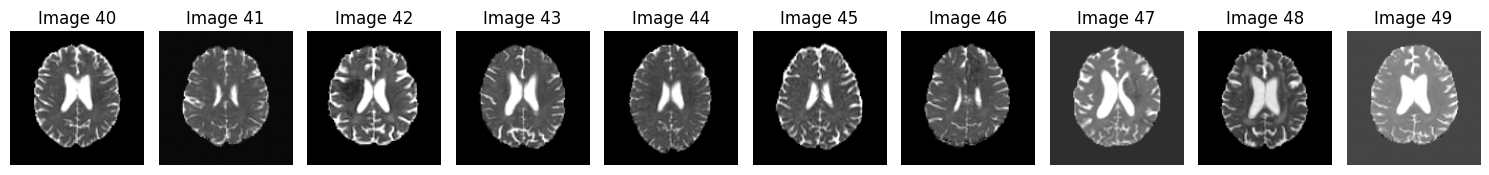

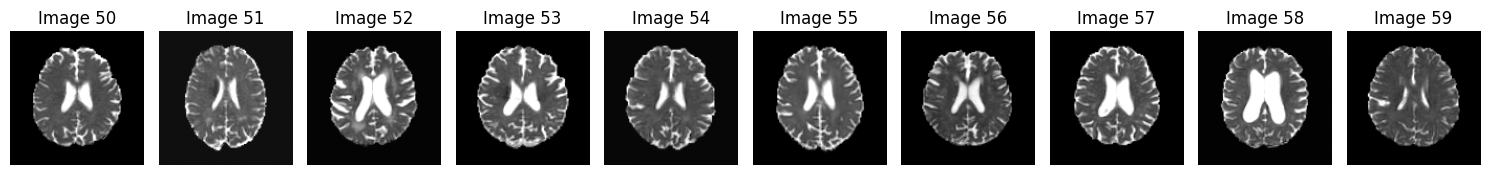

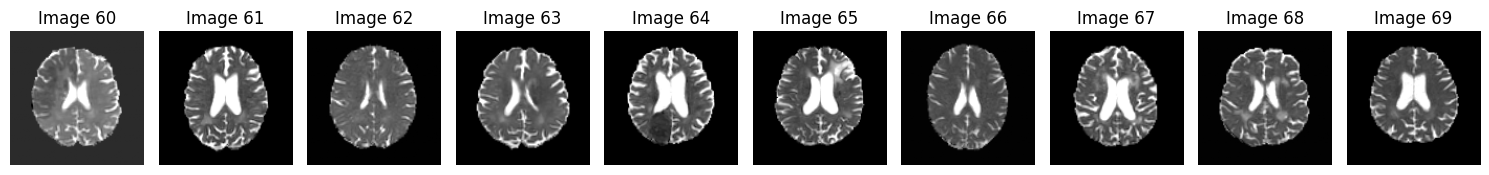

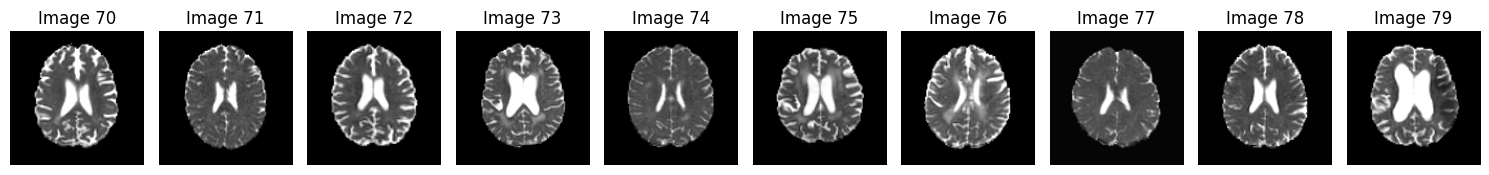

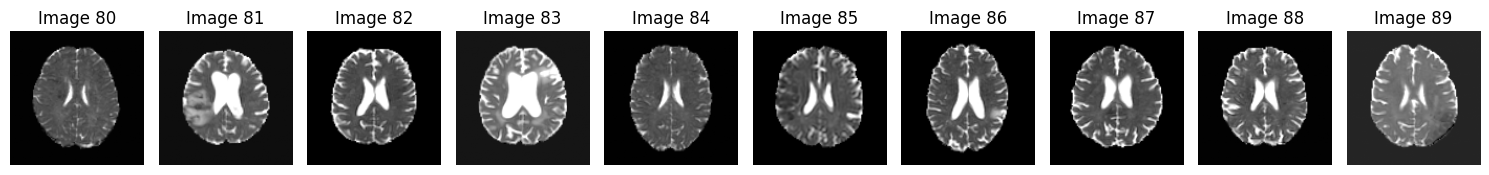

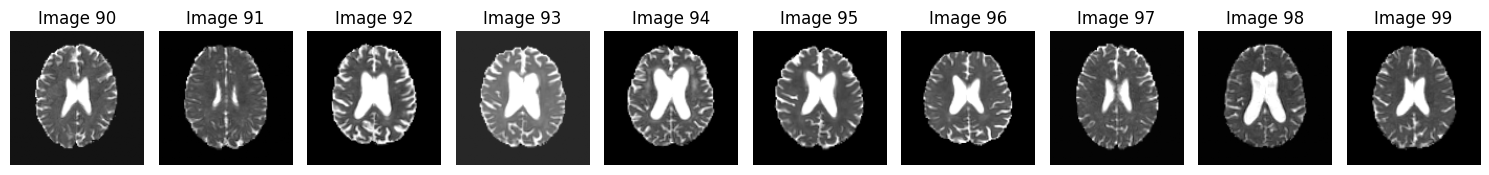

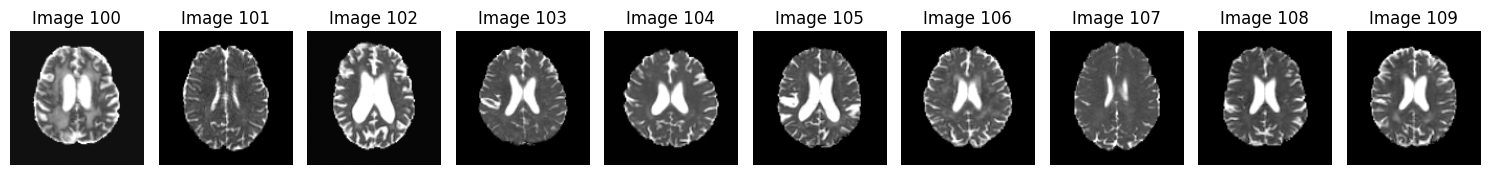

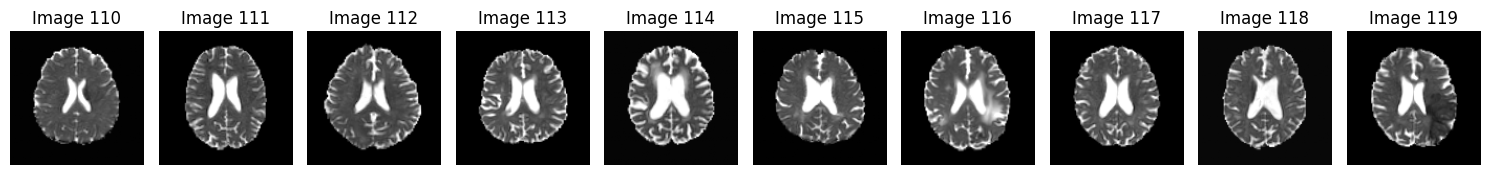

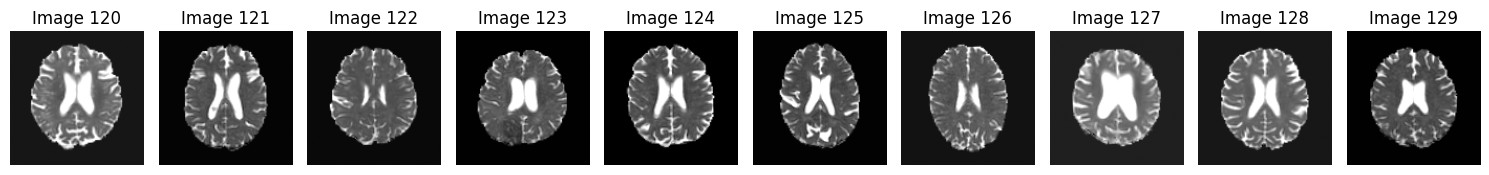

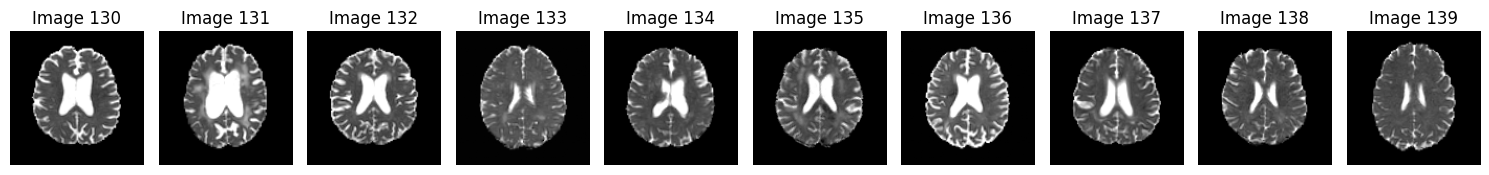

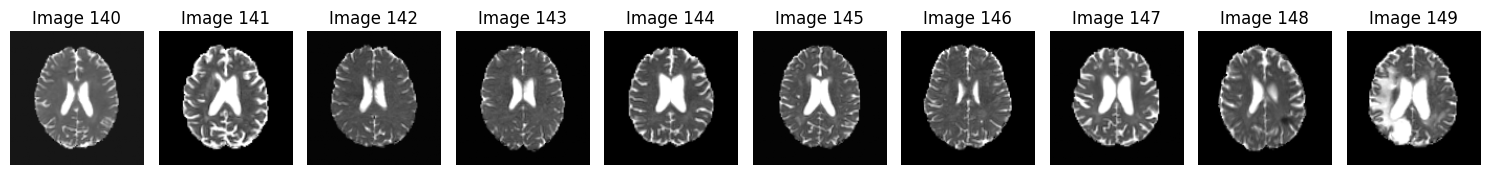

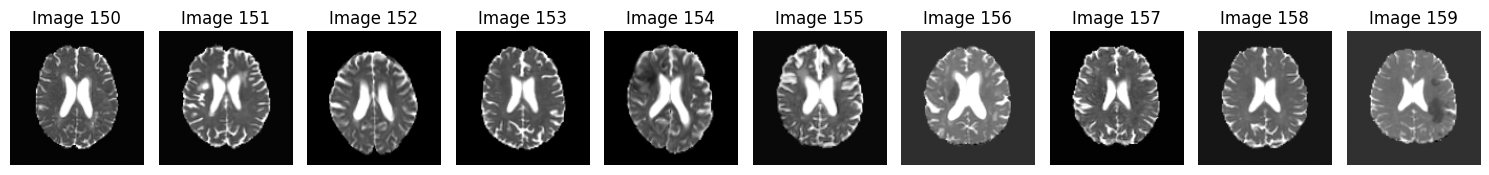

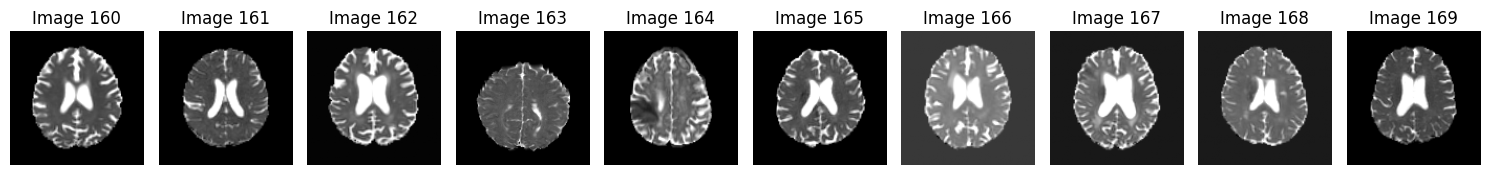

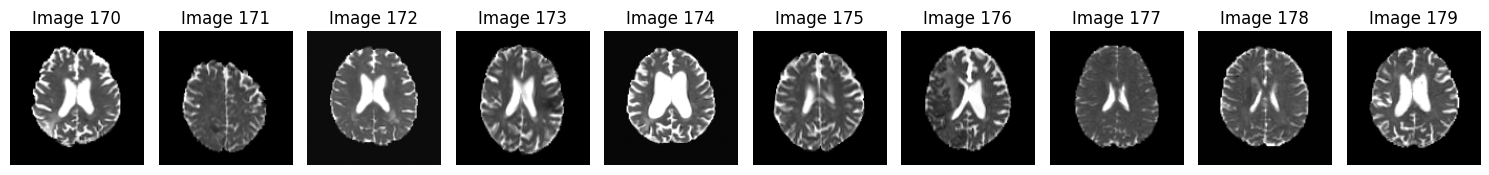

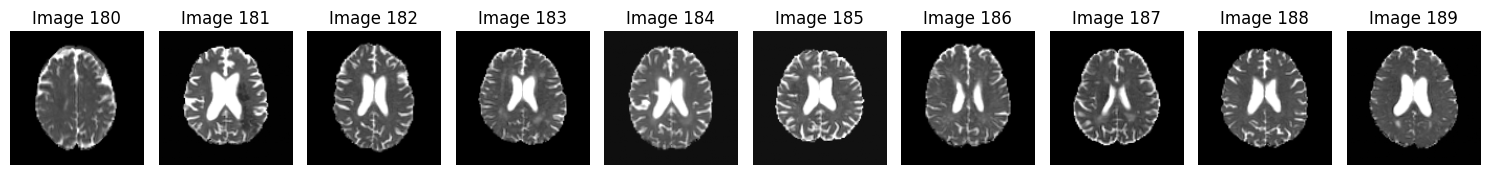

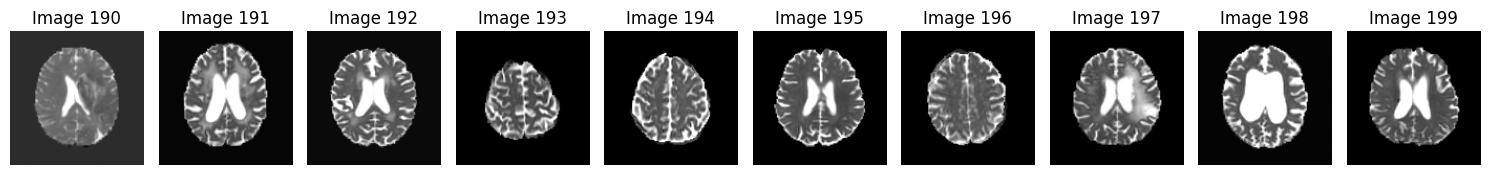

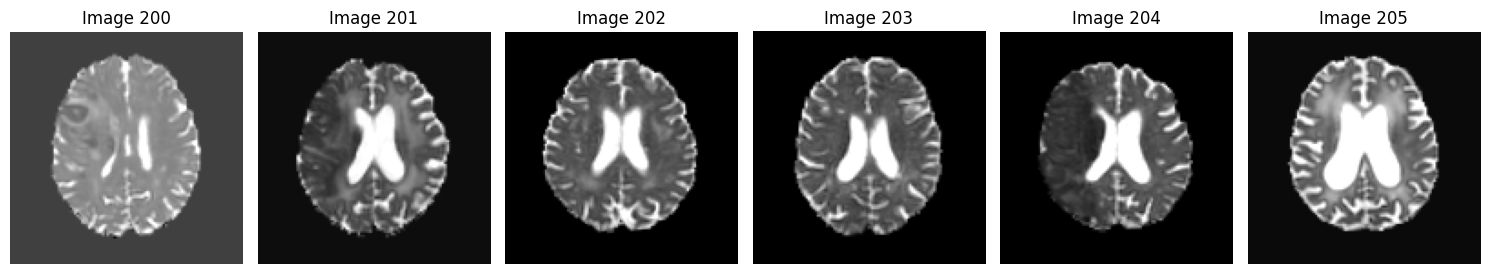

In [16]:
# visualise images after transformation
for batch_number, batch in enumerate(test_anomaly_loader):
    num_images = batch.shape[0]
    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        img = batch[i, 0].cpu().numpy()
        axs[i].imshow(img, cmap="gray", vmin=0, vmax=1)
        axs[i].axis("off")
        axs[i].title.set_text(f"Image {batch_number*anomaly_batch_size + i}")
    plt.tight_layout()
    plt.show()


TODO: Pour chaque threshold, faire faire un truc qui calcule le dice moyen sur toutes les images, et on garde le threshold qui donne le meilleur dice 

Puis nester ça dans un truc qui teste pour tous les niveaux de bruits

Puis faire ça avec Simplex noise

In [17]:





@torch.no_grad()
def my_sample(image, timesteps=100, progress_bar=True):
    
    
    num_infer_timesteps = timesteps #100 # higher number = more noise at first timestep, more denoising steps
    intermediate_steps = num_infer_timesteps//10
    infer_scheduler = DDPMScheduler(num_train_timesteps=num_infer_timesteps)

    all_next_timesteps = torch.cat((scheduler.timesteps[1:], torch.tensor([0], dtype=infer_scheduler.timesteps.dtype)))

    if progress_bar:
        progress_bar = tqdm(
            zip(infer_scheduler.timesteps, all_next_timesteps),
            total=min(len(infer_scheduler.timesteps), len(all_next_timesteps)),
        )
    else:
        progress_bar = zip(infer_scheduler.timesteps, all_next_timesteps)
            
    intermediates = []
            
    for t, next_t in progress_bar:          # va de num_infer_timesteps à 0
        # 1. predict noise model_output
        diffusion_model = model
        
        model_output = diffusion_model(
            image, timesteps=torch.Tensor((t,)).to(device), context=None
        )
        #inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)
        # 2. compute previous image: x_t -> x_t-1
        
        image, _ = infer_scheduler.step(model_output, t, image)
        
        if t % intermediate_steps == 0:
            intermediates.append(image)
    
    return image, intermediates



In [ ]:

num_timesteps_to_try = np.arange(10, 500, 10)
thresholds_to_try = np.arange(0.0, 1.0, 0.01) # from 0.0 to 1.0 with step 0.05

iou_scores_df = pd.DataFrame(index=num_timesteps_to_try, columns=thresholds_to_try)
iou_scores_df.fillna(0.0, inplace=True)

best_iou = 0.0
best_threshold = 0.0
best_num_timesteps = 0


for i,(image_batch, mask_batch) in tqdm(enumerate(zip(test_anomaly_loader, test_masks_loader))): # i=6 batch is nice

    test_images = image_batch.to(device)
    test_masks = mask_batch.to(device)
    test_masks[test_masks>0.5] = 1.0
    test_masks[test_masks<=0.5] = 0.0

    for infer_timesteps in num_timesteps_to_try:
        with autocast(device_type=DEVICE_TYPE, enabled=True):
            infered_image, intermediates = my_sample(test_images, timesteps=infer_timesteps, progress_bar=False)
            #chain = torch.cat(intermediates, dim=-1)
            #plt.figure(figsize=(16, 10))
            #plt.imshow(chain[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
    
        for threshold in thresholds_to_try:
            ano_segmentation = torch.abs(infered_image - test_images) > threshold
            iou_score = compute_iou(ano_segmentation, test_masks)
            flattened_iou_score = iou_score.cpu().numpy().flatten()
            flattened_iou_score[np.isnan(flattened_iou_score)] = 0.0

            if np.isnan(iou_scores_df.loc[infer_timesteps, threshold]): # if the cell is empty
                iou_scores_df.loc[infer_timesteps, threshold] = flattened_iou_score
            else:
                iou_scores_df.loc[infer_timesteps, threshold] = (iou_scores_df.loc[infer_timesteps, threshold]+np.mean(flattened_iou_score))/2


best_iou = iou_scores_df.max().max()
best_threshold = iou_scores_df.max(axis=0).idxmax()
best_num_timesteps = iou_scores_df.max(axis=1).idxmax()

print(f"Best IOU: {best_iou}")
print(f"Best Threshold: {best_threshold}")
print(f"Best Number of Timesteps: {best_num_timesteps}")



/tmp/ipykernel_2509978/3921661251.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  iou_scores_df.fillna(0.0, inplace=True)
21it [17:33:51, 3011.01s/it]

Best IOU: 0.08571659183476088
Best Threshold: 0.22
Best Number of Timesteps: 250


In [19]:
iou_scores_df.to_csv("Experiment_1-2_scores_iou.csv")

### Visualization of ano segmentation

In [ ]:
for i,(image_batch, mask_batch) in tqdm(enumerate(zip(test_anomaly_loader, test_masks_loader))): # i=6 batch is nice
    if i==6:
        test_images = image_batch.to(device)
        test_masks = mask_batch.to(device)
        test_masks[test_masks>0.5] = 1.0
        test_masks[test_masks<=0.5] = 0.0

        with autocast(device_type=DEVICE_TYPE, enabled=True):
            infered_image, intermediates = my_sample(test_images, timesteps=best_num_timesteps, progress_bar=False)

        fig, axs = plt.subplots(anomaly_batch_size, 6, figsize=(16,30))
        plt.tight_layout()

        for j in range(anomaly_batch_size):

            axs[j, 0].title.set_text('original image')
            axs[j, 1].title.set_text('noisy image')
            axs[j, 2].title.set_text('reconstructed image')
            axs[j, 3].title.set_text('simple difference')
            axs[j, 4].title.set_text('Infered anomaly segmentation')
            axs[j, 5].title.set_text('Ground truth mask')

            axs[j, 0].imshow(test_images[j,0].cpu(), vmin=0, vmax=1, cmap="gray")
            axs[j, 1].imshow(intermediates[0][j,0].cpu(), vmin=0, vmax=1, cmap="gray")
            axs[j, 2].imshow(infered_image[j,0].cpu(), vmin=0, vmax=1, cmap="gray")
            axs[j, 3].imshow((infered_image[j,0].cpu() - test_images[j,0].cpu()), vmin=-1, vmax=1, cmap="jet")
            axs[j, 4].imshow(torch.abs(infered_image[j,0].cpu() - test_images[j,0].cpu()) > best_threshold, cmap="gray")
            axs[j, 5].imshow(test_masks[j,0].cpu(), vmin=0, vmax=1, cmap="viridis")
            

les maps d'anomalie ont quand même beaucoup de valeurs non nulles, on devrait pas voir la forme du cerveau

rajouter du random shift intensity dans les augmentations de données ?
